# The Riemann problem for the Euler equations

This is an exact Riemann solver for the one-dimensional Euler equations of compressible flow.  It is based on Sections 14.11-14.12 of [Randall LeVeque's finite volume text](http://depts.washington.edu/clawpack/book.html).

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">This example</span> by <a href="http://davidketcheson.info">David Ketcheson</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  All code examples are also licensed under the [MIT license](http://opensource.org/licenses/MIT).

## Contents

 - <a href="#solver">Riemann solver</a>
 - <a href="#examples">Example Riemann problems</a>
     - <a href="#sod">Sod shock tube</a>
     - <a href="#expansion">Expansion</a>
     - <a href="#collision">Collision</a>
 - <a href="#interact">Interactive widget</a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# <div id="solver"></div>  Riemann solver

The cell below contains the code for the Riemann solver.  In order to be similar to Riemann solvers used in numerical codes, it takes the conserved quantities *(density, momentum, energy)* as inputs.  For convenience, it returns the solution in primitive variables *(density, velocity, pressure)*.

In [3]:
def exact_riemann_solution(q_l,q_r,x=None,t=None,gamma=1.4):
    """Return the exact solution to the Riemann problem with initial states q_l, q_r.
       The solution is computed at time t and points x (where x may be a 1D numpy array).
       
       The input vectors are the conserved quantities but the outputs are [rho,u,p].
    """
    rho_l = q_l[0]
    u_l = q_l[1]/q_l[0]
    E_l = q_l[2]
    
    rho_r = q_r[0]
    u_r = q_r[1]/q_r[0]
    E_r = q_r[2]

    # Compute left and right state pressures
    p_l = (gamma-1.)*(E_l - 0.5*rho_l*u_l**2)
    p_r = (gamma-1.)*(E_r - 0.5*rho_r*u_r**2)

    # Compute left and right state sound speeds
    c_l = np.sqrt(gamma*p_l/rho_l)
    c_r = np.sqrt(gamma*p_r/rho_r)
    
    alpha = (gamma-1.)/(2.*gamma)
    beta = (gamma+1.)/(gamma-1.)

    # Check for cavitation
    if u_l - u_r + 2*(c_l+c_r)/(gamma-1.) < 0:
        print('Cavitation detected!  Exiting.')
        return None
    
    # Define the integral curves and hugoniot loci
    integral_curve_1 = lambda p : u_l + 2*c_l/(gamma-1.)*(1.-(p/p_l)**((gamma-1.)/(2.*gamma)))
    integral_curve_3 = lambda p : u_r - 2*c_r/(gamma-1.)*(1.-(p/p_r)**((gamma-1.)/(2.*gamma)))
    hugoniot_locus_1 = lambda p : u_l + 2*c_l/np.sqrt(2*gamma*(gamma-1.)) * ((1-p/p_l)/np.sqrt(1+beta*p/p_l))
    hugoniot_locus_3 = lambda p : u_r - 2*c_r/np.sqrt(2*gamma*(gamma-1.)) * ((1-p/p_r)/np.sqrt(1+beta*p/p_r))
    
    # Check whether the 1-wave is a shock or rarefaction
    def phi_l(p):        
        if p>=p_l: return hugoniot_locus_1(p)
        else: return integral_curve_1(p)
    
    # Check whether the r-wave is a shock or rarefaction
    def phi_r(p):
        if p>=p_r: return hugoniot_locus_3(p)
        else: return integral_curve_3(p)
        
    phi = lambda p : phi_l(p)-phi_r(p)

    # Compute middle state p, u by finding curve intersection
    p, info, ier, msg = fsolve(phi, (p_l+p_r)/2.,full_output=True,xtol=1.e-14)
    # For strong rarefactions, sometimes fsolve needs help
    if ier!=1:
        p,info, ier, msg = fsolve(phi, (p_l+p_r)/2.,full_output=True,factor=0.1,xtol=1.e-10)
        # This should not happen:
        if ier!=1: 
            print('Warning: fsolve did not converge.')
            print(msg)

    u = phi_l(p)

    
    # Find middle state densities
    rho_l_star = (p/p_l)**(1./gamma) * rho_l
    rho_r_star = (p/p_r)**(1./gamma) * rho_r
        
    # compute the wave speeds
    ws = np.zeros(5) 
    # The contact speed:
    ws[2] = u
    
    # Find shock and rarefaction speeds
    if p>p_l: 
        ws[0] = (rho_l*u_l - rho_l_star*u)/(rho_l - rho_l_star)
        ws[1] = ws[0]
    else:
        c_l_star = np.sqrt(gamma*p/rho_l_star)
        ws[0] = u_l - c_l
        ws[1] = u - c_l_star

    if p>p_r: 
        ws[4] = (rho_r*u_r - rho_r_star*u)/(rho_r - rho_r_star)
        ws[3] = ws[4]
    else:
        c_r_star = np.sqrt(gamma*p/rho_r_star)
        ws[3] = u+c_r_star
        ws[4] = u_r + c_r    
    

    # Compute return values

    # Choose a time based on the wave speeds
    if x is None: x = np.linspace(-1.,1.,1000)
    if t is None: t = 0.8*max(np.abs(x))/max(np.abs(ws))
    
    xs = ws*t # Wave locations
        
    # Find solution inside rarefaction fans
    xi = x/t
    u1 = ((gamma-1.)*u_l + 2*(c_l + xi))/(gamma+1.)
    u3 = ((gamma-1.)*u_r - 2*(c_r - xi))/(gamma+1.)
    rho1 = (rho_l**gamma*(u1-xi)**2/(gamma*p_l))**(1./(gamma-1.))
    rho3 = (rho_r**gamma*(xi-u3)**2/(gamma*p_r))**(1./(gamma-1.))
    p1 = p_l*(rho1/rho_l)**gamma
    p3 = p_r*(rho3/rho_r)**gamma
    
    rho_out = (x<=xs[0])*rho_l + (x>xs[0])*(x<=xs[1])*rho1 + (x>xs[1])*(x<=xs[2])*rho_l_star + (x>xs[2])*(x<=xs[3])*rho_r_star + (x>xs[3])*(x<=xs[4])*rho3 + (x>xs[4])*rho_r
    u_out   = (x<=xs[0])*u_l + (x>xs[0])*(x<=xs[1])*u1 + (x>xs[1])*(x<=xs[2])*u + (x>xs[2])*(x<=xs[3])*u + (x>xs[3])*(x<=xs[4])*u3 + (x>xs[4])*u_r
    p_out   = (x<=xs[0])*p_l + (x>xs[0])*(x<=xs[1])*p1 + (x>xs[1])*(x<=xs[2])*p + (x>xs[2])*(x<=xs[3])*p + (x>xs[3])*(x<=xs[4])*p3 + (x>xs[4])*p_r
    return rho_out, u_out, p_out

# <div id="examples"></div>  Examples

Let's try this solver out on some interesting initial states.  Note that the Euler equations are invariant under Galilean transformations, so we can without loss of generality take $u_l+u_r=0$.

In [4]:
gamma = 7./5.

In [5]:
def plot_exact_riemann_solution(rho_l=3.,u_l=0.,p_l=3.,rho_r=1.,u_r=0.,p_r=1.,t=0.4):
    E_l = p_l/(gamma-1.) + 0.5*rho_l*u_l**2
    E_r = p_r/(gamma-1.) + 0.5*rho_r*u_r**2
    
    q_l = [rho_l, rho_l*u_l, E_l]
    q_r = [rho_r, rho_r*u_r, E_r]
    
    x = np.linspace(-1.,1.,1000)
    rho, u, p = exact_riemann_solution(q_l, q_r, x, t, gamma=gamma)

    fig = plt.figure(figsize=(18,6))
    primitive = [rho,u,p]
    names = ['Density','Velocity','Pressure']
    axes = [0]*3
    for i in range(3):
        axes[i] = fig.add_subplot(1,3,i+1)
        q = primitive[i]
        plt.plot(x,q,linewidth=3)
        plt.title(names[i])
        qmax = max(q)
        qmin = min(q)
        qdiff = qmax - qmin
        axes[i].set_ylim((qmin-0.1*qdiff,qmax+0.1*qdiff))

<div id="sod"></div>

#1: Sod shock tube

First we consider the classic shock tube problem, with high density and pressure on the left, low density and pressure on the right.  Both sides are initially at rest.  The solution includes a rarefaction, a contact, and a shock.

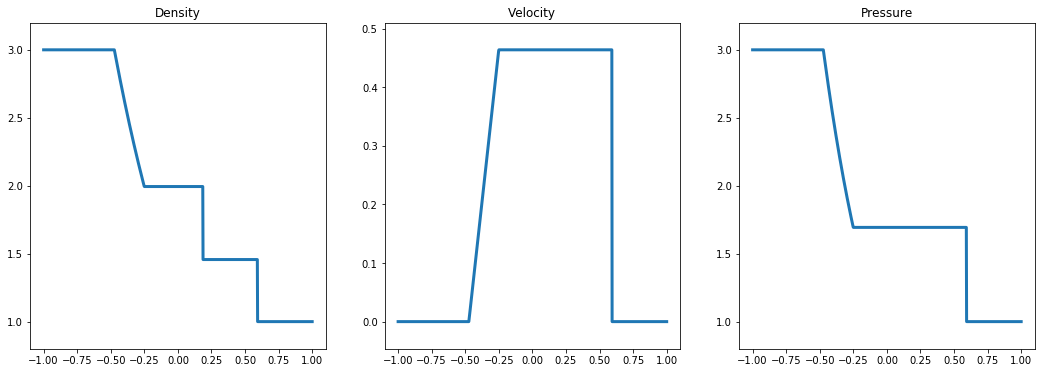

In [6]:
plot_exact_riemann_solution(rho_l=3.,
                            u_l = 0.,
                            p_l = 3.,
                            rho_r=1.,
                            u_r = 0.,
                            p_r = 1.)

## <div id="expansion"></div>  2: Symmetric expansion

Next we consider the case of equal densities and pressures, and equal and opposite velocities, with the initial states moving away from each other.  The result is two rarefaction waves (the contact has zero strength).

/Users/evanschneider/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in power
/Users/evanschneider/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in power


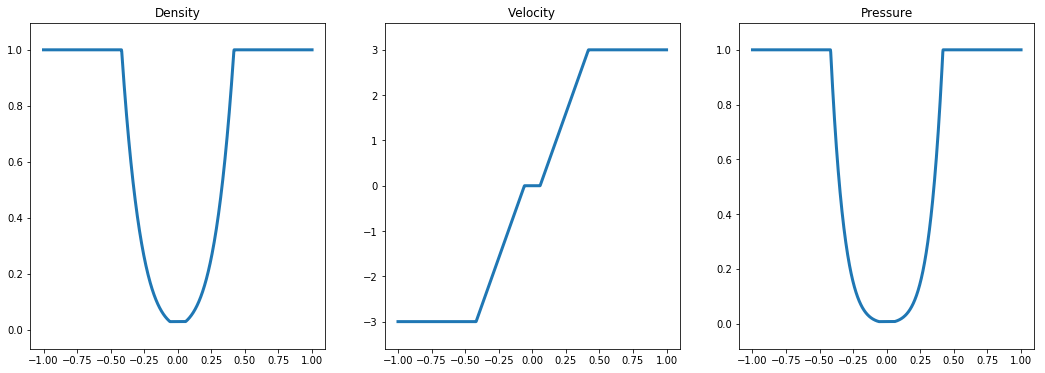

In [7]:
plot_exact_riemann_solution(rho_l=1.,
                            u_l = -3.,
                            p_l = 1.,
                            rho_r=1.,
                            u_r = 3.,
                            p_r = 1.,
                            t = 0.1)

Notice that, by symmetry, we must have $u=0$ in the middle state.  As we make the initial velocities larger in magnitude, the rarefaction waves increase in strength until the pressure and density at $x=0$ reach zero.  In the plot above, the middle pressure is very close but not quite equal to zero.

For what initial velocity $u_r=-u_l$ does the middle pressure vanish?  We can find it by solving the equation that describes the 3- (or 1-) Riemann invariant with $u=p=0$.  For $\rho_r=p_r=1$, this gives $u_r \approx 5.916$.  What happens if the velocities are set to larger than this value in the problem above?

More generally, cavitation occurs if

$$u_l + 2\frac{c_l}{\gamma-1} < u_r + 2\frac{c_r}{\gamma-1}.$$


## <div id="collision"></div>  3: Colliding flows

Next, consider the case in which the left and right states are moving toward eachother.  This leads to a pair of shocks, with a high-density, high-pressure state in between.

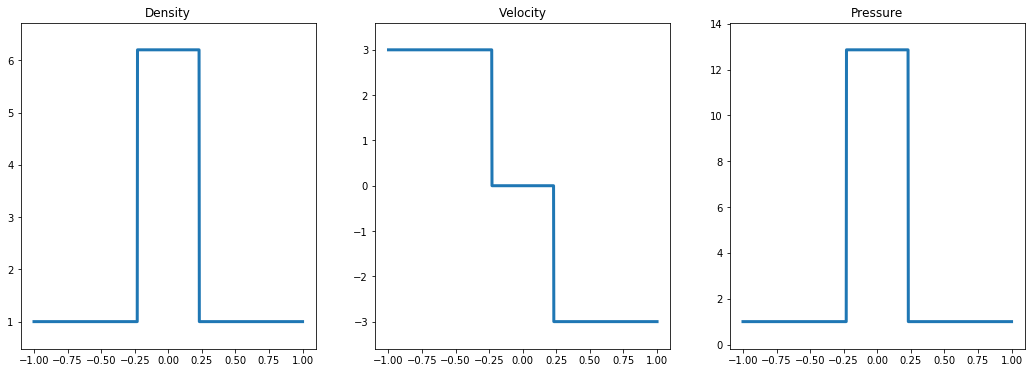

In [8]:
plot_exact_riemann_solution(rho_l=1.,
                            u_l = 3.,
                            p_l = 1.,
                            rho_r=1.,
                            u_r = -3.,
                            p_r = 1.,
                            t = 0.4)

## <div id="interact"></div>  Interactive Riemann solver

Here you can set up your own Riemann problem and immediately see the solution.  If you don't want to download and run the notebook, an online interactive version is [here](http://sagecell.sagemath.org/?z=eJytWNtu47YWfQ-Qf2BnHiLJsmzFGeAgqIsCnfaxOCgGpw-DwJAtOiaOLgwviTJf30VSlKjYSgdog8FEIdfeXPvKLbGat0KRRtf8lRSSNPz6irm1ulC8alXF9hl_NU9mn1fq-uoo2prIA-OvWcsVq9k3Snqho2yrZ3p9dX1V0iOhXXFQO8FoXTTNDltasbaJnnZV-rQTabf9vW1oqtyvx6Kui22e3cX311cEPx8-fPiDKi0aok7U6SJeB1GtXf3D6SZctPuK1uSFqRNhDVOsqIhUhaKSmOPwn8icWvx8geSgiUlyaGuuFS1JoQjsoQS2NiXhLWuUJB2JXk5UUDzUxSvZU1KQ_LP3mRDFazyqnpzBGqglz_SgWiEBpZbzoW0kFc847kkXjQJXkNwDaDZbrSDjwF_FqU11yh-ywSHuAeu7imyNZV_XD25NDyv5wyrc-HXYuO1XRiXC7ohAiV-xSkSgxG8YJW7tI_nF-Y1U9Og8JtjjSTm_IyRUSo3_HJpbGpGN8jLP4iQyxJZknX1KrD0JLEiS29jDxRlcBHABuHDw72IjW40VySkte0IHS6jhmXwSyh2UgOTKkok9RlzACIsRcejNouKnYsJ4Fd1mif2rB-6pGhELixjAgRUnevg_ObaCHIpnBu7IUbfHjjbISxulBblNIpiwAMVQEfmRrO-HJEQQkMLk5pdBFSmpQj7S8gcEtUPuNY_ZzYgXruBMQYbWfSSf6ZE1Ln-hkT4K1NdBI4uldfVJP7YNQ4-o2gPr6fawnYXtcixtSVXU-7IgnNxbW4wVMGIVxjnPlhFfIRJxkkQX3RnHF0_YnJ9gMsacIC6eIP72BG_WDmZpCRtmLfA5cus0JKPamCQkivKls2kA5guTD4lbvXzcZt6c7ztOXDxOxPE0ti7l0OMQXWFDnC9fimdqWmNB5KnFLvJRoCcd0YSHhDQtnp_Yrop4fO8zaMwl5Cv_aQvz7n1avXUn5EY4rSQdkG-TZ0D-W5yF4XzOVcxx3Xw31ymy72YnNo2ld9vSczlvYzUry4r6ZpoSTfavBEVYomRd6dmThaSBeTxlzbFNCaMiJbV8xKnuSo5wUEoiRGNh8-I2S4-6qnbuvtl-EZqmnWorXMB0md_Fns1vcKJUosWZgS9lioZaU3NXyv4A0pjWSk604kO7AosftnnYjv4JPXN2K7brLA-YrgNff8Sli_Aj-LoqSYNudCo4p800zj2pIFGDRvlnIRr4994bVTKnCHf2MxWPNOyVoxgs8fHTMMkH168NvkTwpmEtaSPt_R_c6zts2btvaIJ5tnJtCaVtIcEFPkGLS2jxNhk_-nnHlo0tmvBefJHuyvtGRSujT_Eg9cXNLsrOYUbg3gtgKICMvmCtK0R7GY_ZMznOVp5tEiNPaFwbjdEwGKDxjc5JNHq1m4HC5XiiIDcKrCK3bEt2RBxGR7-53ldzGi0lx-XgYxAept2GlfSh760Tb6y7G6yzc0xvhphaN12ectn01t3NWSfes25Wo154yXO6buowE9EQ5POm1bfE56LSJqnHbt220szNdrreFxLDb9tczj-4rDNd3Mwg93i0JlSskbw40AhXXGr-rde-8oFXI14Bv87-k9RFF0Gu2Muoi-NV8OeLnN5_nbSuTBR4_mnIoOHbUUmeF47L6eHNAcVb0klmHwsv1pmO361U3xbM6BDMGomfHcwMh4eOxX6KW9hx0AptzoTcBBAd7MNFIcQ3H0vHjwc6XwKNeXk1Trpx3y2C2WFQsRnz06vo2FJvpirErApuOOCMxCjJ-5m6V9UjNhYhLGLTT9QTxNjlcAsYPt2P286UYexeGOC2qPupX-k3c7eZD3v5uHfrBV1peMTtiNj0CDFFbEbEnUNshr07L-JfoAxXMmWr57nqWaZ6jqCe46WnrLTnxC9x4vOc-CwnPseJz3HiU07cc-r7RB_c1PktdVSB8Algp7WqxTuyyRLAUjMJdX5yOzIzQfBKZXjCq2aEX5J9o9soX6d3Qy4KVuOSRWVvx1dqt9UUZoDB8s1nexO_3qQ3_6PmHcY-_rd_hb3p4UXn0OuHZNMzwHjE0AjQBJpHGm3CmdKgvzLTOkErK8pyJ_XeWBPl6SZlizxowE_GDs8TQsHIBOusUJc-pWiD9IWV6rTdxFMIXFTRyNoD8VAzWh-Umwb4NFkGaSyzZrpcsuPRvOkbqaVFnRmUSap2rxWro8jsLzGQJVYuNVKL4U_vf_u5CAMyxqKD9B-KcGHUv9mgOdD4twni0KBtOwCfPLszt8n11c925kW3HZNjN_OZydb6Vlbo0QIu_5SayRFCha4U_JfqcXf56c32Ok75u8K25uf2c6NcvK_8PWFAxs9g7vsNn7wlo6jefjcJv9PwyQtvAPZfTcIG-2T1f7W6UjKoTM3BDx4iPEQ4iFVkIGLyTenvb-uhjIF85_OgORKFnhI0BfdhMPySEtQE9A2LQ59Agadd_BeW1ABm&lang=python).

In [10]:
from IPython.display import display, HTML
from IPython.html import widgets
from ipywidgets import interact, interactive

In [11]:
interact(plot_exact_riemann_solution,
         rho_l=(1.,10.,0.1),
         u_l=(-5.,5.,0.1),
         p_l=(1.,10.,0.1),
         rho_r=(1.,10.,0.1),
         u_r=(-5.,5.,0.1),
         p_r=(1.,10.,0.1),
         t=(0.1,1.,0.1));

interactive(children=(FloatSlider(value=3.0, description='rho_l', max=10.0, min=1.0), FloatSlider(value=0.0, d…